In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR # Import the Support Vector Regressor
from sklearn.preprocessing import StandardScaler # Import the scaler
from sklearn.metrics import r2_score

In [7]:
# --- USER CONFIGURATION ---
user_fraction = 0.90   # PERCENTAGE OF DATA TO USE FOR TRAINING (e.g., 0.90)

# SVR Hyperparameters (Tuning these affects results greatly)
C_param = 1000          # Penalty parameter C (higher = less tolerance for errors)
gamma_param = 0.1      # Kernel coefficient (smaller = smoother curve)


try:
    df = pd.read_csv('../Linear_regression/covid_data_clean_with_new_cases.csv')
except FileNotFoundError:
    print("ERROR: File not found. Please check the path.")
    df = pd.DataFrame() 

targets = ['Confirmed', 'Cured', 'Deaths', 'New_Confirmed', 'New_Cured', 'New_Deaths']

--- Support Vector Regression (SVR) | Train Size: 90% ---
C=1000, Gamma=0.1
Target          | Accuracy (R2 Score) 
---------------------------------------------
Confirmed       | -739.7527           
Cured           | -413.6149           
Deaths          | -152.3405           
New_Confirmed   | -3067.5336          
New_Cured       | -1133.0969          
New_Deaths      | -143.4464           


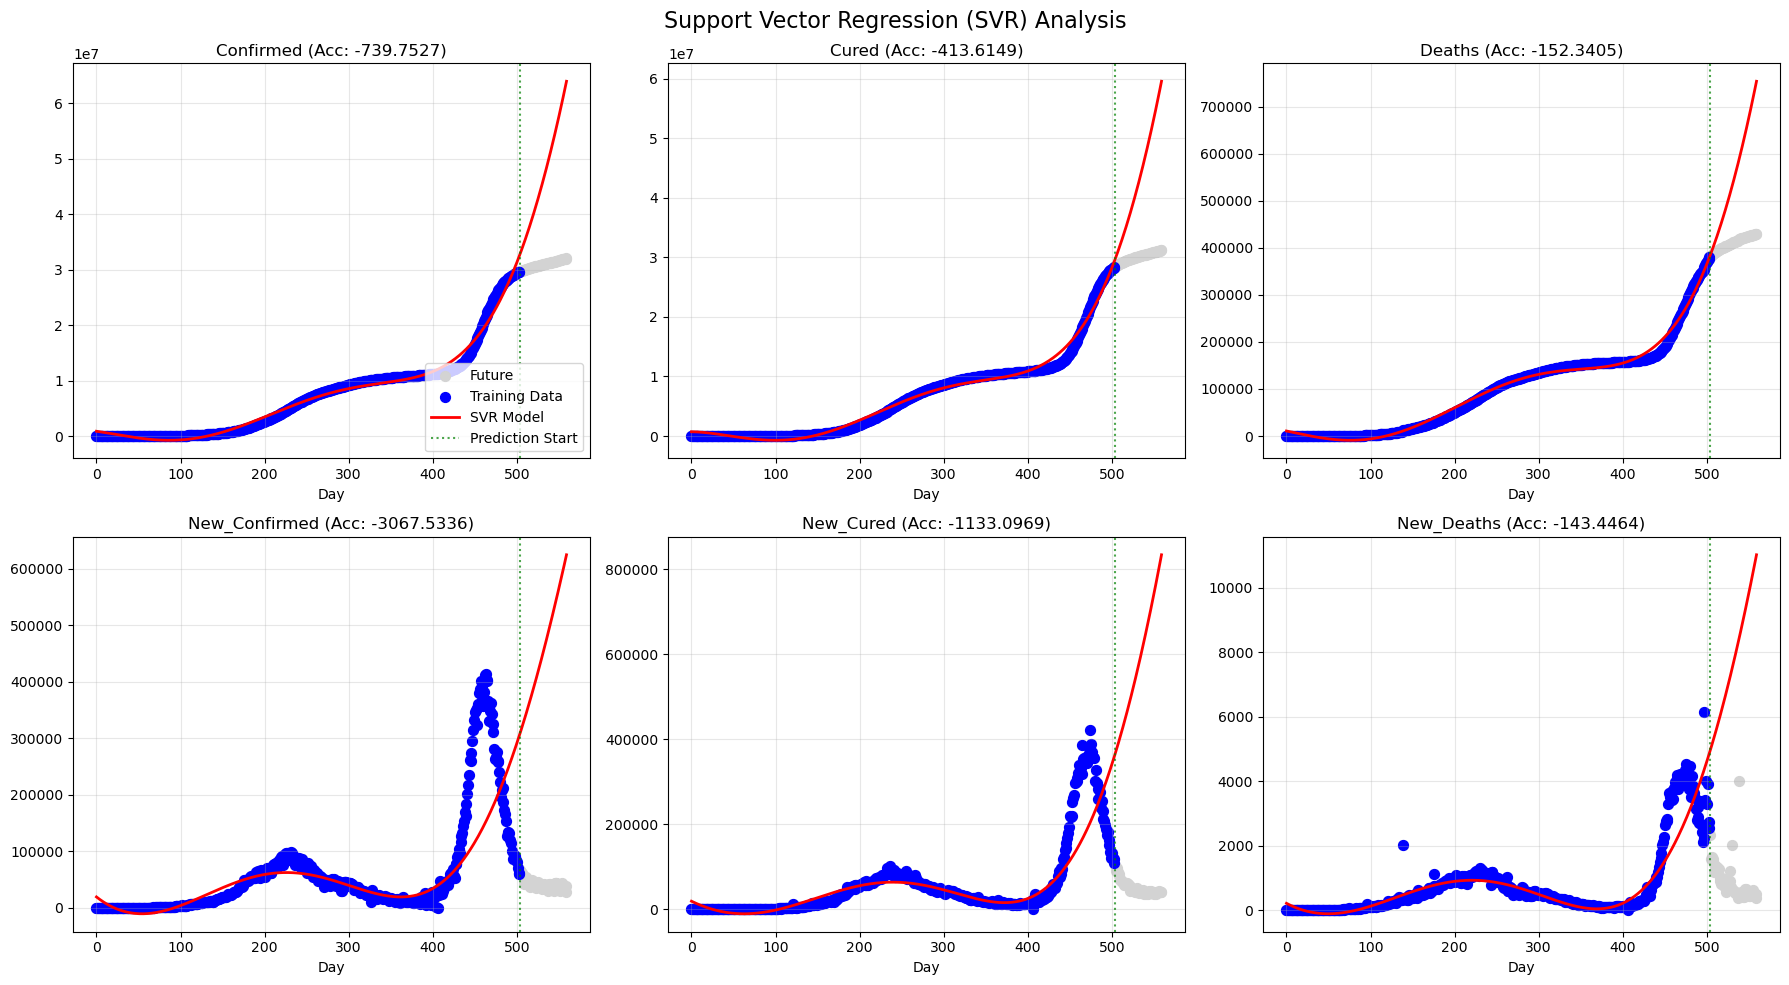

In [8]:
if not df.empty:
    # 1. Setup Scalers
    # We need separate scalers for the input (Day) and the output (Confirmed/Cured/etc.)
    # because they have different scales.
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 2. Setup Plot Grid
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    print(f"--- Support Vector Regression (SVR) | Train Size: {user_fraction*100:.0f}% ---")
    print(f"C={C_param}, Gamma={gamma_param}")
    print(f"{'Target':<15} | {'Accuracy (R2 Score)':<20}")
    print("-" * 45)

    for i, target in enumerate(targets):
        
        # A. Split Data
        n_total = len(df)
        cut_index = int(n_total * user_fraction)
        if cut_index < 2: cut_index = 2
            
        train_df = df.iloc[:cut_index]
        test_df = df.iloc[cut_index:]
        
        # B. Prepare & Scale Data
        # X data (Day)
        X_train_raw = train_df[['Day']]
        X_test_raw = test_df[['Day']]
        
        # Y data (Target) - Reshape for scaler requirement
        y_train_raw = train_df[target].values.reshape(-1, 1)
        y_test_raw = test_df[target].values.reshape(-1, 1)
        
        # Apply Scaling
        X_train_scaled = scaler_X.fit_transform(X_train_raw)
        y_train_scaled = scaler_y.fit_transform(y_train_raw)
        
        # C. Train Model
        # We use the RBF (Radial Basis Function) kernel for non-linear modeling
        model = SVR(kernel='rbf', C=C_param, gamma=gamma_param)
        # SVR needs the y array to be 1-dimensional
        model.fit(X_train_scaled, y_train_scaled.ravel()) 
        
        # D. Predict (Whole Timeline)
        # Scale the full input data, predict, then un-scale the result
        X_all_raw = df[['Day']]
        X_all_scaled = scaler_X.transform(X_all_raw)
        predictions_scaled = model.predict(X_all_scaled)
        predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
        
        # E. Calculate Accuracy (R2 Score) on the unseen 'Future' data
        score_str = "N/A"
        if len(test_df) > 1:
            X_test_scaled = scaler_X.transform(X_test_raw)
            y_pred_test_scaled = model.predict(X_test_scaled)
            # Unscale the predicted test values
            y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
            
            score = r2_score(y_test_raw, y_pred_test)
            score_str = f"{score:.4f}"
            
        print(f"{target:<15} | {score_str:<20}")

        # F. Plotting
        ax = axes[i]
        
        # 1. Plot the "Future" data (light gray)
        ax.scatter(df['Day'], df[target], color='lightgray', s=50, label='Future')
        
        # 2. Plot the Training data (blue)
        ax.scatter(train_df['Day'], train_df[target], color='blue', s=50, label='Training Data')
        
        # 3. Plot the SVR Curve (red line)
        ax.plot(df['Day'], predictions, color='red', linewidth=2, label='SVR Model')
        
        # 4. Draw vertical line at split point 
        ax.axvline(x=cut_index, color='green', linestyle=':', alpha=0.7, label='Prediction Start')
        
        ax.set_title(f'{target} (Acc: {score_str})')
        ax.set_xlabel('Day')
        ax.grid(True, alpha=0.3)
        
        if i == 0: ax.legend(loc='lower right')

    plt.suptitle(f"Support Vector Regression (SVR) Analysis", fontsize=16)
    plt.tight_layout()
    plt.show()